In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tfrbm import BBRBM, GBRBM
import pickle
from collections import Counter

In [15]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets][:, [0,2,3]]

In [16]:
indices_to_one_hot(np.array([[0,0,3,2], [0,3,3,3]]), nb_classes=4)

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [2]:
with open("reduced_many_states_1000_0.p", "rb") as f:
    data = pickle.load(f)

In [3]:
data[0][2].shape

(11, 500)

In [4]:
mags_ = np.array([d[0] for d in data])
kappas = [d[1] for d in data]
#reduced_states = np.array([d[0] for d in data[2]])
#mags_ = np.array([item for sublist in [d[0] for d in data] for item in sublist])
#kappas = np.array([item for sublist in [d[1] for d in data] for item in sublist])
reduced_states = np.array([item for sublist in [d[2] for d in data] for item in sublist])

In [5]:
reduced_states[:3,:10]

array([[ -6.35739023,   7.2136983 ,   1.23121876,  -6.89184799,
          5.86652857, -18.51668198,   9.95202578,  26.99476274,
        -19.14464027, -20.15794942],
       [  3.17642525,  16.03174955,   0.72397739,   4.96030556,
          4.00403575, -13.34779189,  -3.175849  ,   9.60614838,
        -23.81328369, -12.3635043 ],
       [  3.2018941 ,  22.80814305,   0.43344928,  -2.46516071,
          5.91960623, -14.7633423 ,   2.89481588,  22.29903651,
        -23.2420975 ,  -6.35802689]])

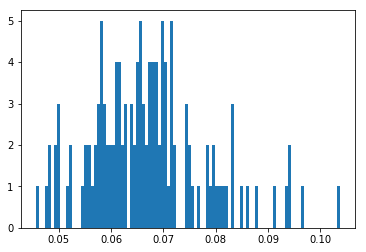

In [12]:
plt.hist(mags_, bins=100)
plt.show()

In [13]:
c = Counter(kappas)
print(c)

Counter({0.105021: 128})


In [14]:
kappa_values = [x for x  in c]

In [15]:
idx = np.where(kappas == kappa_values[0])

In [16]:
import umap

reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=10)
reduced_data = reducer.fit_transform(reduced_states[idx])
#reduced_data = reduced_states[idx]

/home/vladimir/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 11 separate connected components using meta-embedding (experimental)
  n_components


In [17]:
reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, n_components=2)
reduced_data = reducer.fit_transform(reduced_states[idx])

/home/vladimir/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 12 separate connected components using meta-embedding (experimental)
  n_components
/home/vladimir/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


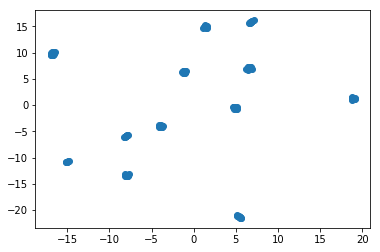

In [18]:
plt.scatter(*reduced_data.T)
plt.show()

In [138]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(reduced_data)

In [139]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, mags_[idx], test_size=0.15, random_state=42)

In [177]:
from tensorflow import keras

clf = keras.Sequential([
    keras.layers.InputLayer(input_shape=(X_scaled[0].size,)),
    keras.layers.Dense(1, activation='linear')
])

clf.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

history = clf.fit(X_train, y_train, epochs=18, batch_size=50)

Epoch 1/18
5440/5440 [==============================] - 0s 65us/sample - loss: 0.9901 - mean_squared_error: 0.9901 - mean_absolute_error: 0.8038
Epoch 2/18
5440/5440 [==============================] - 0s 18us/sample - loss: 0.5545 - mean_squared_error: 0.5545 - mean_absolute_error: 0.5907
Epoch 3/18
5440/5440 [==============================] - 0s 18us/sample - loss: 0.3269 - mean_squared_error: 0.3269 - mean_absolute_error: 0.4526
Epoch 4/18
5440/5440 [==============================] - 0s 21us/sample - loss: 0.2063 - mean_squared_error: 0.2063 - mean_absolute_error: 0.3610
Epoch 5/18
5440/5440 [==============================] - 0s 22us/sample - loss: 0.1355 - mean_squared_error: 0.1355 - mean_absolute_error: 0.2931
Epoch 6/18
5440/5440 [==============================] - 0s 20us/sample - loss: 0.0898 - mean_squared_error: 0.0898 - mean_absolute_error: 0.2387
Epoch 7/18
5440/5440 [==============================] - 0s 20us/sample - loss: 0.0590 - mean_squared_error: 0.0590 - mean_absolute

In [190]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(hidden_layer_sizes=(1, ), learning_rate='adaptive', activation='logistic', tol=1e-2)
clf.fit(X_train, y_train)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.01,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [178]:
y_pred = clf.predict(X_test)

In [179]:
error = y_pred.reshape(1,-1)[0] - y_test

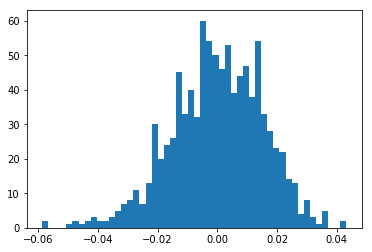

In [180]:
plt.hist(error, bins=50)
plt.show()

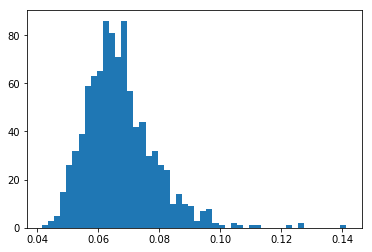

In [181]:
plt.hist(y_test, bins=50)
plt.show()

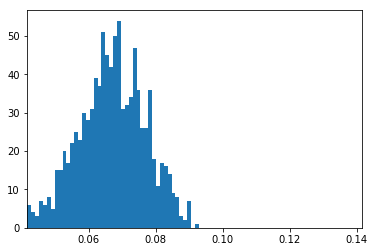

In [182]:
plt.hist(y_pred, bins=50)
plt.xlim([min(y_test), max(y_test)])
plt.show()

In [159]:
from sklearn.preprocessing import MinMaxScaler

scaler_minmax = MinMaxScaler()
X_rbm = scaler_minmax.fit_transform(X_scaled)

Epoch: 0
Train error: 0.0259

Epoch: 1
Train error: 0.0235

Epoch: 2
Train error: 0.0231

Epoch: 3
Train error: 0.0226

Epoch: 4
Train error: 0.0222

Epoch: 5
Train error: 0.0217

Epoch: 6
Train error: 0.0214

Epoch: 7
Train error: 0.0210

Epoch: 8
Train error: 0.0208

Epoch: 9
Train error: 0.0205



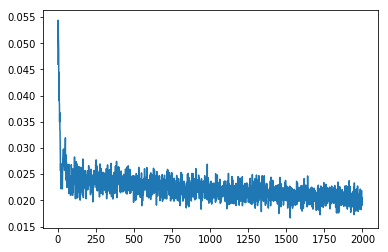

In [160]:
bbrbm = BBRBM(n_visible=X_scaled[0].size, n_hidden=64, learning_rate=0.01, momentum=0.95, use_tqdm=False)
errs = bbrbm.fit(X_rbm, n_epoches=10, batch_size=32)
plt.plot(errs)
plt.show()

In [161]:
new_samples_ = np.array([bbrbm.reconstruct(X_rbm[np.random.randint(0, X_rbm.shape[0])].reshape(1, -1))[0] for i in range(5000)])

In [162]:
new_samples_scaled = scaler_minmax.inverse_transform(new_samples_)
mags_predicted = clf.predict(new_samples_scaled)

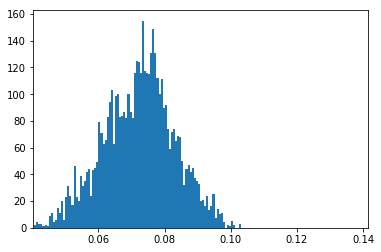

In [163]:
plt.hist(mags_predicted, bins=100)
plt.xlim([min(mags_), max(mags_)])
plt.show()

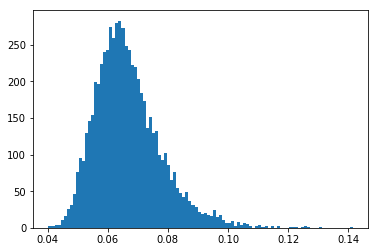

In [151]:
plt.hist(mags_, bins=100)
plt.show()